In [1]:
import os
import sys
import pathlib
import math
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd

from datetime import datetime
import re

In [2]:
data_path = "E:/UG4data"
ids = os.listdir(f"{data_path}/Smile")
long_ids = [f[:-14] for f in os.listdir(f"{data_path}/NHS_processed")]

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Raw data

,respeckTimestamp,sequenceNumber,x,y,z,breathingSignal,breathingRate,activityLevel,activityType
interpolatedPhoneTimestamp,,,,,,,,,
2021-07-07 14:56:48.409,1970-04-09 03:49:53.500,0,-0.315674,-0.635803,0.708679,NaN,NaN,NaN,5
2021-07-07 14:56:48.489,1970-04-09 03:49:53.580,1,-0.323975,-0.653625,0.680603,NaN,NaN,NaN,5
2021-07-07 14:56:48.569,1970-04-09 03:49:53.660,2,-0.342529,-0.622864,0.706726,NaN,NaN,NaN,5
2021-07-07 14:56:48.649,1970-04-09 03:49:53.740,3,-0.343506,-0.536926,0.753357,NaN,NaN,NaN,5
2021-07-07 14:56:48.729,1970-04-09 03:49:53.820,4,-0.339844,-0.448547,0.795593,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...
2021-07-07 21:37:58.758,1970-04-09 10:30:42.123,27,-0.187988,-0.642151,0.726013,0.475676,NaN,0.102685,5
2021-07-07 21:37:58.820,1970-04-09 10:30:42.203,28,-0.179443,-0.627991,0.760193,0.628491,NaN,0.102685,5
2021-07-07 21:37:58.883,1970-04-09 10:30:42.283,29,-0.128906,-0.606018,0.741150,0.786412,NaN,0.102685,5


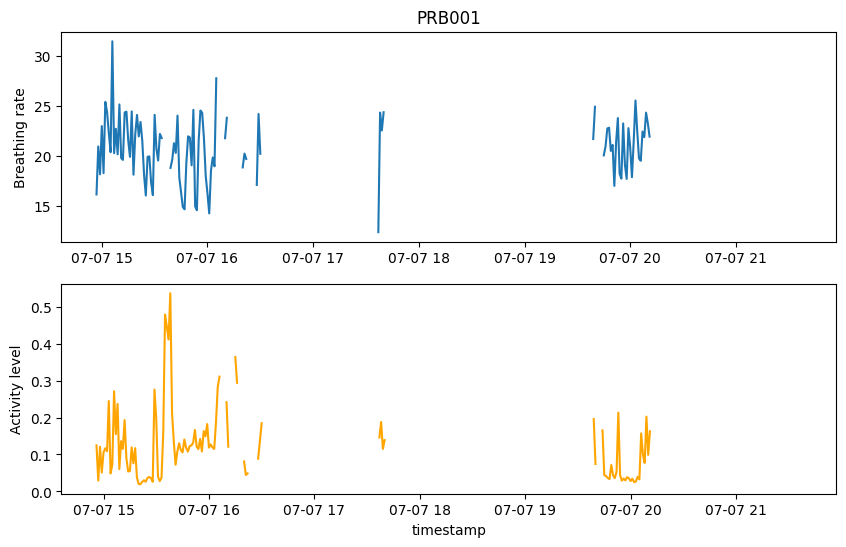

In [4]:
df = pd.read_csv("E:/UG4data/Smile/PRB001/RESpeck/RESpeck PRB001 6df03889fd79ec13 F26A34BD21E9(6AJ) 2021-07-07.csv")
df["respeckTimestamp"] = pd.to_datetime(df['respeckTimestamp'], unit='ms')
df["interpolatedPhoneTimestamp"] = pd.to_datetime(df['interpolatedPhoneTimestamp'], unit='ms')
df.set_index("interpolatedPhoneTimestamp", inplace=True)
display(df)
df = df[["breathingRate", "activityLevel"]].resample('1min').mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
ax1.plot(df[["breathingRate"]])
ax2.plot(df[["activityLevel"]], c='orange')
ax1.set_title("PRB001")
ax2.set_xlabel("timestamp")
ax1.set_ylabel("Breathing rate")
ax2.set_ylabel("Activity level")
plt.show()

## Process data for HAR

In [5]:
def process_for_ml(id):
    n = 1
    path = f"{data_path}/Smile/{id}/RESpeck"
    if not os.path.exists(path):
        print(f"There is no respeck data for {id}!")
        return
    print(f"Processing {id}...")
    files = [f for f in os.listdir(path)]
    for f in files:
        df = pd.read_csv(f"{data_path}/Smile/{id}/RESpeck/{f}", on_bad_lines="skip")
        df["timestamp"] = pd.to_datetime(df['interpolatedPhoneTimestamp'], unit='ms')
        df.set_index("timestamp", inplace=True)
        df = df[["x", "y", "z", "breathingSignal", "breathingRate", "activityLevel"]]
        df.to_csv(f"{data_path}/NHS_processed/{id}({n})_processed.csv")
        n += 1

In [6]:
def aggregate_for_ml(id):
    n = 1
    path = f"{data_path}/Smile/{id}/RESpeck"
    if not os.path.exists(path):
        print(f"There is no respeck data for {id}!")
        return
    if os.path.exists(f"{data_path}/NHS_processed_agg/{id}_processed.csv"):
        print(f"Processed {id} already exists!")
        return
    print(f"Processing {id}...")
    files = [f for f in os.listdir(path)]
    df_agg = pd.DataFrame()
    for f in files:
        df = pd.read_csv(f"{data_path}/Smile/{id}/RESpeck/{f}", on_bad_lines="skip")
        df["timestamp"] = pd.to_datetime(df['interpolatedPhoneTimestamp'], unit='ms')
        df.set_index("timestamp", inplace=True)
        df = df[["x", "y", "z", "breathingSignal", "breathingRate", "activityLevel"]]
#         df = df.resample('1T').mean()
        df["long_id"] = f"{id}({n})"
        n += 1
        df_agg = pd.concat([df_agg, df])
#         df = df.resample('1T').apply({'breathingRate': 'mean', 
#                                       'activityLevel': 'mean', 
#                                       'activityType': lambda x: x.mode() if x.any() else pd.NA}).dropna(how="all")
    df_agg.to_csv(f"{data_path}/NHS_processed_agg/{id}_processed.csv")
#     return df_agg

In [13]:
for id in ids:
    process_for_ml(id)

Processing PRB001...
There is no respeck data for PRB002!
Processing PRB003...
Processing PRB004...
Processing PRB005...
Processing PRB006...
Processing PRB007...
Processing PRB102...
Processing PRB103...
Processing PRB104...
Processing PRB105...
Processing PRB106...
Processing PRB107...
Processing PRB108...
Processing PRB109...
There is no respeck data for PRB111!
Processing PRB201...
Processing PRB202...
Processing PRB203...
Processing PRX018...
Processing PRX900...


In [47]:
long_ids = [f[:-14] for f in os.listdir(f"{data_path}/NHS_processed")]
for long_id in long_ids:
    print(f"Resampling for {long_id}")
    df = pd.read_csv(f"{data_path}/NHS_processed/{long_id}_processed.csv", parse_dates=["timestamp"], index_col=["timestamp"])
    df = df.resample('1T').mean()
    df.to_csv(f"{data_path}/NHS_r1min/{long_id}_r1min.csv")

Resampling for PRB001(1)
Resampling for PRB001(10)
Resampling for PRB001(11)
Resampling for PRB001(12)
Resampling for PRB001(13)
Resampling for PRB001(14)
Resampling for PRB001(15)
Resampling for PRB001(16)
Resampling for PRB001(17)
Resampling for PRB001(18)
Resampling for PRB001(19)
Resampling for PRB001(2)
Resampling for PRB001(20)
Resampling for PRB001(21)
Resampling for PRB001(22)
Resampling for PRB001(23)
Resampling for PRB001(24)
Resampling for PRB001(25)
Resampling for PRB001(26)
Resampling for PRB001(27)
Resampling for PRB001(28)
Resampling for PRB001(29)
Resampling for PRB001(3)
Resampling for PRB001(30)
Resampling for PRB001(31)
Resampling for PRB001(32)
Resampling for PRB001(33)
Resampling for PRB001(34)
Resampling for PRB001(35)
Resampling for PRB001(36)
Resampling for PRB001(37)
Resampling for PRB001(38)
Resampling for PRB001(39)
Resampling for PRB001(4)
Resampling for PRB001(40)
Resampling for PRB001(41)
Resampling for PRB001(42)
Resampling for PRB001(43)
Resampling for P

Resampling for PRB102(54)
Resampling for PRB102(55)
Resampling for PRB102(56)
Resampling for PRB102(57)
Resampling for PRB102(58)
Resampling for PRB102(59)
Resampling for PRB102(6)
Resampling for PRB102(60)
Resampling for PRB102(61)
Resampling for PRB102(7)
Resampling for PRB102(8)
Resampling for PRB102(9)
Resampling for PRB103(1)
Resampling for PRB103(10)
Resampling for PRB103(11)
Resampling for PRB103(12)
Resampling for PRB103(13)
Resampling for PRB103(14)
Resampling for PRB103(15)
Resampling for PRB103(16)
Resampling for PRB103(17)
Resampling for PRB103(18)
Resampling for PRB103(19)
Resampling for PRB103(2)
Resampling for PRB103(20)
Resampling for PRB103(21)
Resampling for PRB103(22)
Resampling for PRB103(23)
Resampling for PRB103(24)
Resampling for PRB103(25)
Resampling for PRB103(26)
Resampling for PRB103(27)
Resampling for PRB103(28)
Resampling for PRB103(29)
Resampling for PRB103(3)
Resampling for PRB103(30)
Resampling for PRB103(31)
Resampling for PRB103(32)
Resampling for PRB1

Resampling for PRB108(4)
Resampling for PRB108(40)
Resampling for PRB108(41)
Resampling for PRB108(42)
Resampling for PRB108(43)
Resampling for PRB108(44)
Resampling for PRB108(45)
Resampling for PRB108(46)
Resampling for PRB108(47)
Resampling for PRB108(48)
Resampling for PRB108(49)
Resampling for PRB108(5)
Resampling for PRB108(50)
Resampling for PRB108(51)
Resampling for PRB108(52)
Resampling for PRB108(53)
Resampling for PRB108(54)
Resampling for PRB108(55)
Resampling for PRB108(56)
Resampling for PRB108(57)
Resampling for PRB108(58)
Resampling for PRB108(6)
Resampling for PRB108(7)
Resampling for PRB108(8)
Resampling for PRB108(9)
Resampling for PRB109(1)
Resampling for PRB109(10)
Resampling for PRB109(11)
Resampling for PRB109(12)
Resampling for PRB109(13)
Resampling for PRB109(14)
Resampling for PRB109(15)
Resampling for PRB109(16)
Resampling for PRB109(17)
Resampling for PRB109(18)
Resampling for PRB109(19)
Resampling for PRB109(2)
Resampling for PRB109(20)
Resampling for PRB10

Resampling for PRX900(23)
Resampling for PRX900(24)
Resampling for PRX900(25)
Resampling for PRX900(26)
Resampling for PRX900(27)
Resampling for PRX900(28)
Resampling for PRX900(29)
Resampling for PRX900(3)
Resampling for PRX900(30)
Resampling for PRX900(31)
Resampling for PRX900(32)
Resampling for PRX900(33)
Resampling for PRX900(34)
Resampling for PRX900(35)
Resampling for PRX900(36)
Resampling for PRX900(37)
Resampling for PRX900(38)
Resampling for PRX900(39)
Resampling for PRX900(4)
Resampling for PRX900(40)
Resampling for PRX900(41)
Resampling for PRX900(42)
Resampling for PRX900(43)
Resampling for PRX900(44)
Resampling for PRX900(45)
Resampling for PRX900(46)
Resampling for PRX900(47)
Resampling for PRX900(48)
Resampling for PRX900(49)
Resampling for PRX900(5)
Resampling for PRX900(50)
Resampling for PRX900(51)
Resampling for PRX900(6)
Resampling for PRX900(7)
Resampling for PRX900(8)
Resampling for PRX900(9)


## Process data for STEP

In [7]:
def choose_class(x):
    x = [i for i in x if i != np.nan]
    if len(x) == 0:
        return np.nan
    else:
        return max(set(x), key = x.count)

def resample_HAR_and_aggregate(long_id, r='1min'):
#     if os.path.exists(f"{data_path}/NHS_HAR_r{r}/{long_id}_r{r}.csv"):
#         print(f"Processed {long_id} already exists!")
#         return
    print(f"Processing {long_id}...")
#     df_HAR = pd.read_csv(f"{data_path}/NHS_HAR_raw/{long_id}.csv", parse_dates=["timestamp"], index_col=["timestamp"])
    df_HAR = pd.read_csv(f"{data_path}/NHS_HAR_raw/{long_id}.csv")
    df_HAR['timestamp'] = pd.to_datetime(df_HAR['timestamp'], format='mixed')
    df_HAR = df_HAR.set_index('timestamp')
    if r:
        df_HAR = df_HAR.resample(r).apply(lambda x: choose_class(x))
    display(df_HAR)
    df = pd.read_csv(f"{data_path}/NHS_r{r}/{long_id}_r{r}.csv", parse_dates=["timestamp"], index_col=["timestamp"])
    df = df.merge(df_HAR, left_index=True, right_index=True, how="outer")
    df.to_csv(f"{data_path}/NHS_HAR_r{r}/{long_id}_r{r}.csv")

In [39]:
long_ids = [f[:-14] for f in os.listdir(f"{data_path}/NHS_processed")]
for long_id in long_ids:
    resample_HAR_and_aggregate(file_name)

Processing PRB001(1)...
Processing PRB001(10)...
Processing PRB001(11)...
Processing PRB001(12)...
Processing PRB001(13)...
Processing PRB001(14)...
Processing PRB001(15)...
Processing PRB001(16)...
Processing PRB001(17)...
Processing PRB001(18)...
Processing PRB001(19)...
Processing PRB001(2)...
Processing PRB001(20)...
Processing PRB001(21)...
Processing PRB001(22)...
Processing PRB001(23)...
Processing PRB001(24)...
Processing PRB001(25)...
Processing PRB001(26)...
Processing PRB001(27)...
Processing PRB001(28)...
Processing PRB001(29)...
Processing PRB001(3)...
Processing PRB001(30)...
Processing PRB001(31)...
Processing PRB001(32)...
Processing PRB001(33)...
Processing PRB001(34)...
Processing PRB001(35)...
Processing PRB001(36)...
Processing PRB001(37)...
Processing PRB001(38)...
Processing PRB001(39)...
Processing PRB001(4)...
Processing PRB001(40)...
Processing PRB001(41)...
Processing PRB001(42)...
Processing PRB001(43)...
Processing PRB001(44)...
Processing PRB001(45)...
Proc

Processing PRB103(10)...
Processing PRB103(11)...
Processing PRB103(12)...
Processing PRB103(13)...
Processing PRB103(14)...
Processing PRB103(15)...
Processing PRB103(16)...
Processing PRB103(17)...
Processing PRB103(18)...
Processing PRB103(19)...
Processing PRB103(2)...
Processing PRB103(20)...
Processing PRB103(21)...
Processing PRB103(22)...
Processing PRB103(23)...
Processing PRB103(24)...
Processing PRB103(25)...
Processing PRB103(26)...
Processing PRB103(27)...
Processing PRB103(28)...
Processing PRB103(29)...
Processing PRB103(3)...
Processing PRB103(30)...
Processing PRB103(31)...
Processing PRB103(32)...
Processing PRB103(33)...
Processing PRB103(34)...
Processing PRB103(35)...
Processing PRB103(36)...
Processing PRB103(37)...
Processing PRB103(38)...
Processing PRB103(39)...
Processing PRB103(4)...
Processing PRB103(40)...
Processing PRB103(41)...
Processing PRB103(42)...
Processing PRB103(43)...
Processing PRB103(44)...
Processing PRB103(45)...
Processing PRB103(46)...
Pro

Processing PRB109(11)...
Processing PRB109(12)...
Processing PRB109(13)...
Processing PRB109(14)...
Processing PRB109(15)...
Processing PRB109(16)...
Processing PRB109(17)...
Processing PRB109(18)...
Processing PRB109(19)...
Processing PRB109(2)...
Processing PRB109(20)...
Processing PRB109(3)...
Processing PRB109(4)...
Processing PRB109(5)...
Processing PRB109(6)...
Processing PRB109(7)...
Processing PRB109(8)...
Processing PRB109(9)...
Processing PRB201(1)...
Processing PRB201(10)...
Processing PRB201(11)...
Processing PRB201(12)...
Processing PRB201(13)...
Processing PRB201(14)...
Processing PRB201(15)...
Processing PRB201(16)...
Processing PRB201(17)...
Processing PRB201(18)...
Processing PRB201(19)...
Processing PRB201(2)...
Processing PRB201(20)...
Processing PRB201(21)...
Processing PRB201(22)...
Processing PRB201(23)...
Processing PRB201(24)...
Processing PRB201(25)...
Processing PRB201(26)...
Processing PRB201(27)...
Processing PRB201(28)...
Processing PRB201(29)...
Processing

In [49]:
df = pd.read_csv(f"{data_path}/NHS_HAR_raw/PRB201(46).csv")
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
df = df.set_index('timestamp').resample('30s')
display(df)

In [76]:
resample_HAR_and_aggregate('PRB005(15)', '30s')

Processing PRB005(15)...


,final_class
timestamp,
2022-04-19 07:38:00,7
2022-04-19 07:38:30,11
2022-04-19 07:39:00,11
2022-04-19 07:39:30,12
2022-04-19 07:40:00,11
2022-04-19 07:40:30,11
2022-04-19 07:41:00,7
2022-04-19 07:41:30,11
2022-04-19 07:42:00,11


## Visualization

In [4]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [5]:
df_score = pd.read_csv('results/NHS/df_scores.csv', parse_dates=["date"])
ids = df_score.id.unique()
ids = np.delete(ids, 11)
ids

array(['PRB001', 'PRB003', 'PRB005', 'PRB006', 'PRB007', 'PRB102',
       'PRB103', 'PRB104', 'PRB105', 'PRB107', 'PRB108', 'PRB201',
       'PRB202', 'PRB203', 'PRX018', 'PRX900'], dtype=object)

In [6]:
long_ids = os.listdir("E:/UG4data/NHS_HAR_r30s")
df_agg = pd.DataFrame()
for id in ids:
    df_id = pd.DataFrame()
    for long_id in long_ids:
        if long_id.startswith(id):
            df = pd.read_csv(f"E:/UG4data/NHS_HAR_r30s/{long_id}", parse_dates=["timestamp"])
            # df = pd.DataFrame(df[['breathingRate', 'activityLevel']].mean()).T
            df['long_id'] = long_id[:-9]
            df_id = pd.concat([df_id, df])
    df_id['id'] = id
    df_agg = pd.concat([df_agg, df_id])
df_agg

,timestamp,x,y,z,breathingSignal,breathingRate,activityLevel,final_class,long_id,id
0,2021-07-07 14:56:30,-0.329332,-0.322042,0.846119,NaN,NaN,0.124682,7.0,PRB001(1),PRB001
1,2021-07-07 14:57:00,-0.407358,-0.129483,0.852978,-0.107426,18.791992,0.034900,7.0,PRB001(1),PRB001
2,2021-07-07 14:57:30,-0.430030,-0.121190,0.849182,0.023066,14.592236,0.024000,7.0,PRB001(1),PRB001
3,2021-07-07 14:58:00,-0.470001,-0.079545,0.831082,-0.049296,19.319344,0.164924,7.0,PRB001(1),PRB001
4,2021-07-07 14:58:30,-0.393332,-0.155498,0.853625,0.059914,23.078850,0.076700,7.0,PRB001(1),PRB001
...,...,...,...,...,...,...,...,...,...,...
2876,2021-10-07 22:57:30,-0.636814,-0.122403,0.745061,0.021336,15.599241,0.012207,5.0,PRX900(9),PRX900
2877,2021-10-07 22:58:00,-0.652567,-0.136873,0.733741,-0.013993,15.534555,0.013351,5.0,PRX900(9),PRX900
2878,2021-10-07 22:58:30,-0.645506,-0.134296,0.738774,-0.000705,16.152563,0.010275,5.0,PRX900(9),PRX900
2879,2021-10-07 22:59:00,-0.643492,-0.133159,0.740269,0.000641,17.046728,0.011434,5.0,PRX900(9),PRX900


In [17]:
df_agg['breathingRate'].isna().sum() / len(df_agg)

0.38576907775041014

In [19]:
df_agg['activityLevel'].isna().sum() / len(df_agg)

0.20882777611386527

In [18]:
len(long_ids)

989

In [ ]:
fig = make_subplots(rows=2, cols=1)
fig.add_hline(y=df_agg.breathingRate.mean(), line_dash="dot", row=1, col=1)
fig.add_hline(y=df_agg.activityLevel.mean(), line_dash="dot", row=2, col=1)
# fig = px.box(df_agg, x="id", y="breathingRate")
# for id in ids[:1]:
#     fig.add_trace(go.Box(y=df_agg[df_agg.id==id].breathingRate, name=id, color="smoker"), row=1, col=1)
#     fig.add_trace(go.Box(y=df_agg[df_agg.id==id].activityLevel, name=id, color="smoker"), row=2, col=1)
fig.add_trace(go.Box(y=df_agg.breathingRate, x=df_agg.id, notched=True, boxpoints=False), row=1, col=1)
fig.add_trace(go.Box(y=df_agg.activityLevel, x=df_agg.id, notched=True, boxpoints=False), row=2, col=1)
fig.add_hline(y=df_agg.breathingRate.mean(), line_dash="dot", row=1, col=1)
fig.add_hline(y=df_agg.activityLevel.mean(), line_dash="dot", row=2, col=1)
fig.update_layout(
    title="Distribution of Breathing Rate and Activity Level over 30s resolution",
    xaxis2_title="Subject id",
    yaxis1_title="Breathing Rate",
    yaxis2_title="Activity Level",
    autosize=False,
    width=1000,
    height=600,
    showlegend=False
)
fig.show()

In [31]:
# Group by 'id' and calculate min, max, and count of records
summary_df = df_agg.groupby('id').agg(
    start=pd.NamedAgg(column='timestamp', aggfunc='min'),
    end=pd.NamedAgg(column='timestamp', aggfunc='max'),
    count=pd.NamedAgg(column='timestamp', aggfunc='count')
).reset_index()

# Calculate duration in days and expected count (assuming 30s intervals, 24h/day)
summary_df['duration_days'] = (summary_df['end'] - summary_df['start']).dt.days
summary_df['expected_count'] = summary_df['duration_days'] * (24 * 60 * 2)  # 24 hours * 60 minutes * 2 (for 30s intervals)
summary_df['completeness'] = summary_df['count'] / summary_df['expected_count'] * 100
summary_df

,id,start,end,count,duration_days,expected_count,completeness
0,PRB001,2021-07-07 14:56:30,2021-09-09 10:02:00,99936,63,181440,55.079365
1,PRB003,2021-08-18 10:29:00,2021-11-08 09:43:30,130644,81,233280,56.003086
2,PRB005,2022-03-21 08:37:00,2022-07-04 11:26:00,116916,105,302400,38.662698
3,PRB006,2022-04-06 11:49:00,2022-05-26 18:12:00,89364,50,144000,62.058333
4,PRB007,2022-07-01 06:00:30,2022-08-24 08:14:00,110185,54,155520,70.849408
5,PRB102,2021-06-15 07:45:00,2021-08-18 10:03:30,163070,64,184320,88.471137
6,PRB103,2021-08-12 07:45:30,2021-11-08 13:24:30,140402,88,253440,55.398516
7,PRB104,2021-08-20 10:06:30,2021-11-15 11:03:00,159810,87,250560,63.781130
8,PRB105,2021-09-27 13:40:00,2021-12-06 18:21:00,185160,70,201600,91.845238
9,PRB107,2022-03-07 12:28:00,2022-06-12 17:07:30,140783,97,279360,50.394831


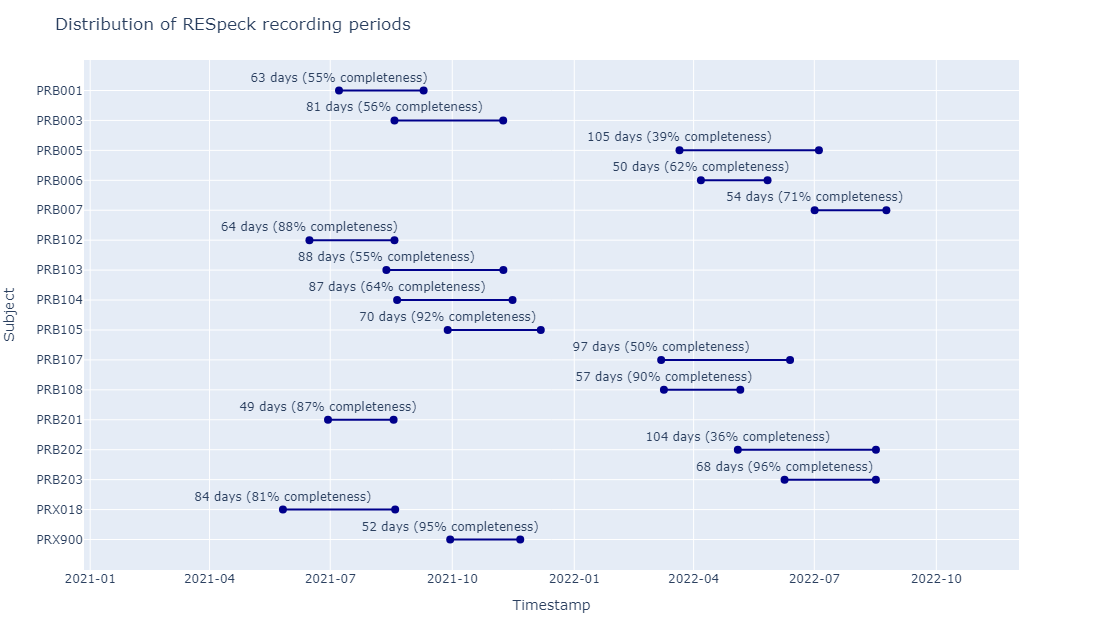

In [67]:
fig = go.Figure()

global_start = summary_df['start'].min()
global_end = summary_df['end'].max()
xaxis_start = global_start - pd.Timedelta(days=150)
xaxis_end = global_end + pd.Timedelta(days=100)

for i, row in summary_df.iterrows():
    # Add a line and markers for each subject's recording period
    fig.add_trace(go.Scatter(
        x=[row['start'], row['end']],
        y=[row['id'], row['id']],
        mode='lines+markers+text',
        name=row['id'],
        text=[f"{int(row['duration_days'])} days ({row['completeness']:.0f}% completeness)", ''],
        textposition="top center",
        marker=dict(size=8),  # Customize marker size
        line=dict(color="darkblue")
    ))


# Adjust layout
fig.update_layout(
    title="Distribution of RESpeck recording periods",
    xaxis_title="Timestamp",
    yaxis_title="Subject",
    xaxis=dict(tickformat='%Y-%m', range=[xaxis_start, xaxis_end]),
    yaxis = dict(categoryorder='array', autorange="reversed"),
    autosize=False,
    width=600,
    height=630,
    showlegend=False,
    margin=dict(t=60, b=60)
)

fig.show()

In [24]:
df_agg

,timestamp,x,y,z,breathingSignal,breathingRate,activityLevel,final_class,long_id,id
0,2021-07-07 14:56:30,-0.329332,-0.322042,0.846119,NaN,NaN,0.124682,7.0,PRB001(1),PRB001
1,2021-07-07 14:57:00,-0.407358,-0.129483,0.852978,-0.107426,18.791992,0.034900,7.0,PRB001(1),PRB001
2,2021-07-07 14:57:30,-0.430030,-0.121190,0.849182,0.023066,14.592236,0.024000,7.0,PRB001(1),PRB001
3,2021-07-07 14:58:00,-0.470001,-0.079545,0.831082,-0.049296,19.319344,0.164924,7.0,PRB001(1),PRB001
4,2021-07-07 14:58:30,-0.393332,-0.155498,0.853625,0.059914,23.078850,0.076700,7.0,PRB001(1),PRB001
...,...,...,...,...,...,...,...,...,...,...
2876,2021-10-07 22:57:30,-0.636814,-0.122403,0.745061,0.021336,15.599241,0.012207,5.0,PRX900(9),PRX900
2877,2021-10-07 22:58:00,-0.652567,-0.136873,0.733741,-0.013993,15.534555,0.013351,5.0,PRX900(9),PRX900
2878,2021-10-07 22:58:30,-0.645506,-0.134296,0.738774,-0.000705,16.152563,0.010275,5.0,PRX900(9),PRX900
2879,2021-10-07 22:59:00,-0.643492,-0.133159,0.740269,0.000641,17.046728,0.011434,5.0,PRX900(9),PRX900


In [29]:
df_agg.long_id.unique()

array(['PRB001(1)', 'PRB001(10)', 'PRB001(11)', 'PRB001(12)',
       'PRB001(13)', 'PRB001(14)', 'PRB001(15)', 'PRB001(16)',
       'PRB001(17)', 'PRB001(18)', 'PRB001(19)', 'PRB001(2)',
       'PRB001(20)', 'PRB001(21)', 'PRB001(22)', 'PRB001(23)',
       'PRB001(24)', 'PRB001(25)', 'PRB001(26)', 'PRB001(27)',
       'PRB001(28)', 'PRB001(29)', 'PRB001(3)', 'PRB001(30)',
       'PRB001(31)', 'PRB001(32)', 'PRB001(33)', 'PRB001(34)',
       'PRB001(35)', 'PRB001(36)', 'PRB001(37)', 'PRB001(38)',
       'PRB001(39)', 'PRB001(4)', 'PRB001(40)', 'PRB001(41)',
       'PRB001(42)', 'PRB001(43)', 'PRB001(44)', 'PRB001(45)',
       'PRB001(46)', 'PRB001(47)', 'PRB001(48)', 'PRB001(49)',
       'PRB001(5)', 'PRB001(50)', 'PRB001(51)', 'PRB001(52)',
       'PRB001(53)', 'PRB001(54)', 'PRB001(55)', 'PRB001(56)',
       'PRB001(57)', 'PRB001(58)', 'PRB001(59)', 'PRB001(6)',
       'PRB001(60)', 'PRB001(7)', 'PRB001(8)', 'PRB001(9)', 'PRB003(1)',
       'PRB003(10)', 'PRB003(11)', 'PRB003(12)', 'P

In [ ]:
df_001 = df_agg[df_agg.long_id == 'PRB003(2)'][['timestamp', 'breathingSignal']]
df_001 = df_001.set_index('timestamp')
df_001.plot()

## Process data for sleep-wake classification

In [ ]:
# Resample respeck recording to 30s
for long_id in long_ids:
    print(f"Resampling for {long_id}")
    df = pd.read_csv(f"{data_path}/NHS_processed/{long_id}_processed.csv", parse_dates=["timestamp"])
    df.set_index("timestamp", inplace=True)
    df = df.resample('30s').mean()
    df.to_csv(f"{data_path}/NHS_r30s/{long_id}_r30s.csv")

In [118]:
# Resample HAR results to 30s
for long_id in long_ids:
    if not long_id == "PRB103(62)":
        resample_HAR_and_aggregate(long_id, "30S", "30s")

Processed PRB001(1) already exists!
Processed PRB001(10) already exists!
Processed PRB001(11) already exists!
Processed PRB001(12) already exists!
Processed PRB001(13) already exists!
Processed PRB001(14) already exists!
Processed PRB001(15) already exists!
Processed PRB001(16) already exists!
Processed PRB001(17) already exists!
Processed PRB001(18) already exists!
Processed PRB001(19) already exists!
Processed PRB001(2) already exists!
Processed PRB001(20) already exists!
Processed PRB001(21) already exists!
Processed PRB001(22) already exists!
Processed PRB001(23) already exists!
Processed PRB001(24) already exists!
Processed PRB001(25) already exists!
Processed PRB001(26) already exists!
Processed PRB001(27) already exists!
Processed PRB001(28) already exists!
Processed PRB001(29) already exists!
Processed PRB001(3) already exists!
Processed PRB001(30) already exists!
Processed PRB001(31) already exists!
Processed PRB001(32) already exists!
Processed PRB001(33) already exists!
Proc

Processing PRB103(8)...
Processing PRB103(9)...
Processing PRB104(1)...
Processing PRB104(10)...
Processing PRB104(11)...
Processing PRB104(12)...
Processing PRB104(13)...
Processing PRB104(14)...
Processing PRB104(15)...
Processing PRB104(16)...
Processing PRB104(17)...
Processing PRB104(18)...
Processing PRB104(19)...
Processing PRB104(2)...
Processing PRB104(20)...
Processing PRB104(21)...
Processing PRB104(22)...
Processing PRB104(23)...
Processing PRB104(24)...
Processing PRB104(25)...
Processing PRB104(26)...
Processing PRB104(27)...
Processing PRB104(28)...
Processing PRB104(29)...
Processing PRB104(3)...
Processing PRB104(30)...
Processing PRB104(31)...
Processing PRB104(32)...
Processing PRB104(33)...
Processing PRB104(34)...
Processing PRB104(35)...
Processing PRB104(36)...
Processing PRB104(37)...
Processing PRB104(38)...
Processing PRB104(39)...
Processing PRB104(4)...
Processing PRB104(40)...
Processing PRB104(41)...
Processing PRB104(42)...
Processing PRB104(43)...
Proces

Processing PRB201(46)...
Processing PRB201(47)...
Processing PRB201(48)...
Processing PRB201(49)...
Processing PRB201(5)...
Processing PRB201(50)...
Processing PRB201(6)...
Processing PRB201(7)...
Processing PRB201(8)...
Processing PRB201(9)...
Processing PRB202(1)...
Processing PRB202(10)...
Processing PRB202(11)...
Processing PRB202(12)...
Processing PRB202(13)...
Processing PRB202(14)...
Processing PRB202(15)...
Processing PRB202(16)...
Processing PRB202(17)...
Processing PRB202(18)...
Processing PRB202(19)...
Processing PRB202(2)...
Processing PRB202(20)...
Processing PRB202(21)...
Processing PRB202(22)...
Processing PRB202(23)...
Processing PRB202(24)...
Processing PRB202(25)...
Processing PRB202(26)...
Processing PRB202(27)...
Processing PRB202(28)...
Processing PRB202(29)...
Processing PRB202(3)...
Processing PRB202(30)...
Processing PRB202(31)...
Processing PRB202(32)...
Processing PRB202(33)...
Processing PRB202(34)...
Processing PRB202(35)...
Processing PRB202(36)...
Processi

In [39]:
# Handling corrpted recordings
df = pd.read_csv(f"{data_path}/NHS_processed/PRB201(47)_processed.csv", parse_dates=["timestamp"])
display(df) # Last row of PRB201(47) has a unix timestamp of 0
df = df[:-1]
df.set_index("timestamp", inplace=True)
df = df.resample('30s').mean()
df.to_csv(f"{data_path}/NHS_r30s/PRB201(47)_r30s.csv")

,timestamp,x,y,z,breathingSignal,breathingRate,activityLevel
0,2021-08-13 22:59:57.427,0.904785,-0.148743,0.314636,0.061575,NaN,0.018458
1,2021-08-13 22:59:57.521,0.907471,-0.145813,0.312683,0.058693,NaN,0.018456
2,2021-08-13 22:59:57.615,0.907715,-0.148010,0.309021,0.053705,NaN,0.018456
3,2021-08-13 22:59:57.710,0.906982,-0.150940,0.309509,0.052003,NaN,0.018456
4,2021-08-13 22:59:57.804,0.906250,-0.145325,0.309265,0.048313,NaN,0.018456
...,...,...,...,...,...,...,...
527376,2021-08-14 20:11:04.345,-0.613037,-0.095520,0.763367,0.083552,NaN,0.022025
527377,2021-08-14 20:11:04.425,-0.612305,-0.097717,0.757263,0.105714,NaN,0.022025
527378,2021-08-14 20:11:04.505,-0.609619,-0.097473,0.757507,0.125587,NaN,0.022025
527379,2021-08-14 20:11:04.585,-0.610352,-0.095764,0.764343,0.136445,NaN,0.022025


In [75]:
# Handling corrpted recordings
df = pd.read_csv(f"{data_path}/NHS_processed/PRB005(15)_processed.csv", parse_dates=["timestamp"])
display(df) # Last row of PRB005(15) is corrpted
df = df[:-1]
df['breathingRate'] = df['breathingRate'].astype(float)
df.set_index("timestamp", inplace=True)
df = df.resample('30s').mean()
df.to_csv(f"{data_path}/NHS_r30s/PRB005(15)_r30s.csv")

,timestamp,x,y,z,breathingSignal,breathingRate,activityLevel
0,2022-04-19 07:38:29.044,-0.047119,-1.054749,0.139587,NaN,NaN,0.771092
1,2022-04-19 07:38:29.124,0.034180,-0.977600,0.110535,NaN,NaN,0.771092
2,2022-04-19 07:38:29.204,0.053467,-0.984924,0.161560,NaN,NaN,0.771092
3,2022-04-19 07:38:29.284,0.089111,-0.991028,0.149597,NaN,NaN,0.771092
4,2022-04-19 07:38:29.364,0.232422,-0.998108,0.217468,NaN,NaN,0.771092
...,...,...,...,...,...,...,...
18655,2022-04-19 08:03:12.824,0.145020,-0.839172,0.482361,-0.791390,NaN,0.110858
18656,2022-04-19 08:03:12.904,0.203369,-0.765198,0.500427,-1.102384,NaN,0.110858
18657,2022-04-19 08:03:12.984,0.279053,-0.812805,0.479919,-1.446462,NaN,0.110858
18658,2022-04-19 08:03:13.064,0.327637,-0.805725,0.475037,-1.859420,NaN,0.110858


In [3]:
# Zac's code: Generating Respiratory Rate Variability (RRV)
def generate_RRV(sliced):
    sliced = sliced.dropna()
    if sliced.size == 0:
        return np.nan
    breathingSignal = sliced.values
    N = breathingSignal.shape[-1]
    y = breathingSignal
    yf = np.fft.fft(y)
    yff = 2.0/N * np.abs(yf[:N//2])
    temp_DCnotremov = yff
    if len(temp_DCnotremov) == 0 or len(temp_DCnotremov) == 1: 
        return 0.0
    else:
        DC = np.amax(temp_DCnotremov)
        maxi = np.argmax(temp_DCnotremov)
        temp_DCremov = np.delete(temp_DCnotremov, maxi)
        H1 = np.amax(temp_DCremov)
        return 100-(H1/DC)*100

In [61]:
def resample_secondary_features(long_id):
#     if os.path.exists(f"{data_path}/NHS_HAR_secondary/{long_id}_secondary.csv"):
#         print(f"Processed {long_id} already exists!")
#         return
    try:
        print(f"Processing {long_id}...")
        df = pd.read_csv(f"{data_path}/NHS_HAR_r30s/{long_id}_r30s.csv", parse_dates=["timestamp"], index_col=["timestamp"])
#         df = pd.read_csv(f"{data_path}/NHS_processed/{long_id}_processed.csv", parse_dates=["timestamp"], index_col=["timestamp"])
        df["breathingSignal"] = df["breathingSignal"].apply(lambda x: 0 if x > 0 else x)
    
        resampled_df = pd.DataFrame()
        resampled_df["BR_md"] = df[["breathingRate"]].resample('30S').median()
        resampled_df["BR_mean"] = df[["breathingRate"]].resample('30S').mean()
        resampled_df["BR_std"] = df[["breathingRate"]].resample('30S').std()
        resampled_df["BR_cov"] = resampled_df["BR_std"] / resampled_df["BR_mean"]
    
        resampled_df["AL_md"] = df[["activityLevel"]].resample('30S').median()
        resampled_df["AL_mean"] = df[["activityLevel"]].resample('30S').mean()
        resampled_df["AL_std"] = df[["activityLevel"]].resample('30S').std()
        resampled_df["AL_cov"] = resampled_df["AL_std"] / resampled_df["AL_mean"]
        
        resampled_df["RRV"] = df[["breathingSignal"]].resample('30S').apply(generate_RRV)
        resampled_df["RRV"] = resampled_df["RRV"].replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')
        # average of 3 Neighbours
        resampled_df["RRV3ANN"] = resampled_df["RRV"].rolling(window=3, center = True).mean()
        resampled_df["RRV3ANN"] = resampled_df["RRV3ANN"] * 0.65
    
#         resampled_df = resampled_df.join(df_HAR, how='outer')
        # Remove the first and last entry as they have no meaningful averages
        resampled_df = resampled_df.iloc[1:-1]
        resampled_df.to_csv(f"{data_path}/NHS_HAR_secondary/{long_id}_secondary.csv")
#         display(resampled_df)
    except Exception as e: 
        print(f'{long_id} run into "{e}"!')

In [62]:
resample_secondary_features('PRB201(47)')

Processing PRB201(47)...


## CAT sorces

In [3]:
for id in ids:
    path = f"{data_path}/Smile/{id}/Diary/"
    if os.path.exists(path):
        print(id)
        file_path = path + os.listdir(path)[0]
        df = pd.read_csv(file_path, index_col=["timestamp"])
        ind = [d.date() for d in pd.to_timedelta(df.index, unit='s') + pd.to_datetime('1970-1-1')]
        df.index = ind
        for long_id in [i for i in long_ids if i.startswith(id)]:
            df_re = pd.read_csv(f"{data_path}/NHS_HAR_r30s/{long_id}_r30s.csv", parse_dates=["timestamp"], index_col=["timestamp"])
            df_re["date"] = df_re.index.floor("D")
            df_re["CAT"] = df_re["date"].map(df["answer9"])
            for i in range(1, 9):
                df_re[f"CAT_{i}"] = df_re["date"].map(df[f"answer{i}"])
            if df_re["CAT_7"].isnull().sum() != len(df_re):
                df_secondary = pd.read_csv(f"{data_path}/NHS_HAR_secondary/{long_id}_secondary.csv", parse_dates=["timestamp"], index_col=["timestamp"])
                df_re = df_re.join(df_secondary.drop("final_class", axis=1))
                df_re.to_csv(f"{data_path}/NHS_CAT_r30s/{long_id}_r30.csv")
                print(f"Saving to {long_id}...")
    else:
        print(f"No diary file for {id}!")

No diary file for PRB001!
No diary file for PRB002!
PRB003
Saving to PRB003(10)...
Saving to PRB003(11)...
Saving to PRB003(12)...
Saving to PRB003(13)...
Saving to PRB003(14)...
Saving to PRB003(15)...
Saving to PRB003(2)...
Saving to PRB003(27)...
Saving to PRB003(28)...
Saving to PRB003(29)...
Saving to PRB003(3)...
Saving to PRB003(30)...
Saving to PRB003(34)...
Saving to PRB003(35)...
Saving to PRB003(36)...
Saving to PRB003(4)...
Saving to PRB003(41)...
Saving to PRB003(42)...
Saving to PRB003(5)...
Saving to PRB003(6)...
Saving to PRB003(7)...
Saving to PRB003(8)...
Saving to PRB003(9)...
PRB004
Saving to PRB004(1)...
Saving to PRB004(2)...
Saving to PRB004(3)...
PRB005
Saving to PRB005(17)...
Saving to PRB005(18)...
Saving to PRB005(2)...
Saving to PRB005(3)...
PRB006
Saving to PRB006(10)...
Saving to PRB006(11)...
Saving to PRB006(16)...
Saving to PRB006(17)...
Saving to PRB006(2)...
Saving to PRB006(20)...
Saving to PRB006(21)...
Saving to PRB006(22)...
Saving to PRB006(23)..

FileNotFoundError: [Errno 2] No such file or directory: 'E:/UG4data/NHS_HAR_r30s/PRB103(62)_r30s.csv'

## Breathing patterns

In [4]:
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
if (os.getcwd() + "\\breathing") not in sys.path:
    sys.path.append(os.getcwd() + "\\breathing")

In [5]:
sys.path

['D:\\Programs\\Python\\Python3.10\\python310.zip',
 'D:\\Programs\\Python\\Python3.10\\DLLs',
 'D:\\Programs\\Python\\Python3.10\\lib',
 'D:\\Programs\\Python\\Python3.10',
 '',
 'D:\\Programs\\Python\\Python3.10\\lib\\site-packages',
 'D:\\Programs\\Python\\Python3.10\\lib\\site-packages\\win32',
 'D:\\Programs\\Python\\Python3.10\\lib\\site-packages\\win32\\lib',
 'D:\\Programs\\Python\\Python3.10\\lib\\site-packages\\Pythonwin',
 'D:\\ProgramData\\Jupyter Notebook\\UG4',
 'D:\\ProgramData\\Jupyter Notebook\\UG4\\breathing']

In [6]:
import warnings; warnings.filterwarnings('ignore')
from collections import defaultdict
from IPython.display import display
from breathing.breathing import *
from multiprocessing import Pool
from scipy.stats import mode

In [7]:
# Philip's code
def countLocalMaximas(values):
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] > values[1]:
        count += 1
    if len(values) > 1 and values[-1] > values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] > values[i - 1] and values[i] > values[i + 1]:
            count += 1
    return count

def countLocalMinimas(values):
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] < values[1]:
        count += 1
    if len(values) > 1 and values[-1] < values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] < values[i - 1] and values[i] < values[i + 1]:
            count += 1
    return count

def getBreaths(df, patient):
    minThreshold = 0.001
    mult = 1e-2
    
    signal = list(df.breathingSignal)
    
    time_diff = df['timestamp'].diff()
    time_diff.map(lambda x: x.total_seconds()).mean()
    
    window_size = int((30 / time_diff.dropna().apply(lambda x: x.total_seconds()).mean()) // 2)
    threshs = calculateThresholdLevels(list(signal), window_size, window_size, mult, False)
    posThresh = threshs[:, 0]
    negThresh = threshs[:, 1]

    times = calculateBreathTimes(list(signal), posThresh, negThresh, minThreshold, False)

    total = set()
    minBreathLength = float("inf")
    maxBreathLength = float("-inf")
    for i in range(0, len(times)):
        vals = times[i]
        for j in range(0, len(vals)-1):
            start, end = vals[j], vals[j+1]
            minBreathLength = min(minBreathLength, end-start+1)
            maxBreathLength = max(maxBreathLength, end-start+1)
            for k in range(start, end+1):
                total.add(k)

    f = list(df.breathingSignal.dropna())
    a = f"{patient}: Uses Breath From {len(total)}/{len(f)} = {round((len(total)/len(f)) * 100, 2)}% Signal"
    b = f"{patient}: Max Breath Length: {maxBreathLength} points. Min Breath Length: {minBreathLength} points"
    print(a)
    print(b)
    
    # file_path = 'logs/processingData.txt'
    # with open(file_path, 'a') as file:  
    #     file.write("\n\n" + a + "\n" + b + "\n\n")
        
    return times

def extractFeatures(df, patient):
    times = getBreaths(df, patient)
    areas = []
    extremas = []
    peakRespiratoryFlows = []
    types = []
    durations = []
    activityLevels = []
    activityTypes = []
    starts = []
    ends = []

    activityLevel = np.array(df.activityLevel)
    activityType = np.array(df.activityType)
    signal = np.array(df.breathingSignal)
    timestamps = list(df.timestamp)

    for i in range(0, len(times)):
#         if i % 25 == 0:
#             print(f"{i}/{len(times)}... ", end=" ")
        vals = times[i]
        
        for j in range(0, len(vals)-1):
            start, end = vals[j], vals[j+1]
            flag = False
            breath = signal[start:end+1]
            breakPoint = start
            for k, val in enumerate(breath):
                if val >= 0.005: # arbitrary but to remove noise...
                    breakPoint = start + k
                    break

            # compute inhalation
            inhalation, inhalation_times = signal[start:breakPoint], timestamps[start:breakPoint]
            exhalation, exhalation_times = signal[breakPoint:end+1], timestamps[breakPoint:end+1]
                    
            level = activityLevel[start:end+1].mean()
            modeType = mode(activityType[start:end+1])[0]
            
            # compute inhalation
            if len(inhalation) > 1:
                peak = max(abs(np.array(inhalation)))
                extrema = countLocalMaximas(inhalation)
                dx = (inhalation_times[-1]-inhalation_times[0]).total_seconds() / len(inhalation)
                area = abs(np.trapz(y=inhalation,dx=dx))
                duration = (inhalation_times[-1]-inhalation_times[0]).total_seconds()
                
                areas.append(area)
                extremas.append(extrema)
                peakRespiratoryFlows.append(peak)
                types.append("Inhalation")
                durations.append(duration)
                activityLevels.append(level)
                activityTypes.append(modeType)
                starts.append(inhalation_times[0])
                ends.append(inhalation_times[-1])

            # compute exhalation
            if len(exhalation) > 1:
                peak = max(abs(np.array(exhalation)))
                extrema = countLocalMinimas(exhalation)    
                dx = (exhalation_times[-1]-exhalation_times[0]).total_seconds() / len(exhalation)
                area = abs(np.trapz(y=exhalation,dx=dx))  
                duration = (exhalation_times[-1]-exhalation_times[0]).total_seconds()
                
                areas.append(area)
                extremas.append(extrema)
                peakRespiratoryFlows.append(peak)
                types.append("Exhalation")
                durations.append(duration)
                activityLevels.append(level)
                activityTypes.append(modeType)
                starts.append(exhalation_times[0])
                ends.append(exhalation_times[-1])

    return pd.DataFrame(data={"type": types, "area": areas, "peakRespiratoryFlow": peakRespiratoryFlows, "extremas": extremas, "duration": durations, "meanActivityLevel": activityLevels, "modeActivityType": activityTypes, "startTimestamp": starts, "endTimestamp": ends})
    
def getAllData(df, patient):
    volumeDf = extractFeatures(df, patient)
    return volumeDf

In [22]:
for id in ids:
    dfs = pd.DataFrame()
    for long_id in [f for f in long_ids if f.startswith(id)]:
        if not os.path.exists(f"{data_path}/NHS_HAR_raw_agg/{long_id}.csv"):
            continue
        df = pd.read_csv(f"{data_path}/NHS_HAR_raw_agg/{long_id}.csv", parse_dates=["timestamp"])
        df = df.rename({"final_class": "activityType"}, axis=1)
        try:
            dfs = pd.concat([dfs, getAllData(df, long_id)])
        except Exception as e: 
            print(f"Error in {long_id}: ", e)
            
    if len(dfs) == 0:
        print(f"No data for {id}. Skip. \n")
        continue

    dfs = dfs.set_index("startTimestamp")[["area", "peakRespiratoryFlow", "extremas", "duration"]].resample('30s').mean()
    dfs["id"] = id
    # dfs["date"] = dfs.startTimestamp.dt.date
    # dfs = dfs[["area", "peakRespiratoryFlow", "extremas", "duration", "date"]].groupby("date").mean()
    print(f"Finished calculation for {id} \n")
    # display(dfs)
    dfs.to_csv(f"{data_path}/NHS_breathing/{id}.csv")

PRB001(1): Uses Breath From 59267/72932 = 81.26% Signal
PRB001(1): Max Breath Length: 176 points. Min Breath Length: 5 points
PRB001(10): Uses Breath From 16490/24715 = 66.72% Signal
PRB001(10): Max Breath Length: 92 points. Min Breath Length: 5 points
PRB001(11): Uses Breath From 48529/59471 = 81.6% Signal
PRB001(11): Max Breath Length: 144 points. Min Breath Length: 5 points
PRB001(12): Uses Breath From 209817/295193 = 71.08% Signal
PRB001(12): Max Breath Length: 158 points. Min Breath Length: 5 points
PRB001(13): Uses Breath From 111623/149952 = 74.44% Signal
PRB001(13): Max Breath Length: 162 points. Min Breath Length: 5 points
PRB001(14): Uses Breath From 156097/214423 = 72.8% Signal
PRB001(14): Max Breath Length: 175 points. Min Breath Length: 5 points
PRB001(15): Uses Breath From 289838/444427 = 65.22% Signal
PRB001(15): Max Breath Length: 174 points. Min Breath Length: 5 points
PRB001(16): Uses Breath From 126177/301064 = 41.91% Signal
PRB001(16): Max Breath Length: 140 points.

In [39]:
df = pd.read_csv(f"{data_path}/NHS_HAR_raw_agg/{long_ids[0]}.csv", parse_dates=["timestamp"])
df = df.rename({"final_class": "activityType"}, axis=1)
vdf = getAllData(df, long_ids[0])
vdf["date"] = vdf.startTimestamp.dt.date
vdf

PRB001(1): Uses Breath From 59267/72932 = 81.26% Signal
PRB001(1): Max Breath Length: 176 points. Min Breath Length: 5 points


,type,area,peakRespiratoryFlow,extremas,duration,meanActivityLevel,modeActivityType,startTimestamp,endTimestamp,date
0,Inhalation,0.304017,0.487322,3,0.960,0.073388,7.0,2021-07-07 14:57:11.449,2021-07-07 14:57:12.409,2021-07-07
1,Exhalation,0.028619,0.120425,2,0.640,0.073388,7.0,2021-07-07 14:57:12.489,2021-07-07 14:57:13.129,2021-07-07
2,Inhalation,0.185135,0.202345,2,1.360,0.022629,7.0,2021-07-07 14:57:13.129,2021-07-07 14:57:14.489,2021-07-07
3,Exhalation,0.579076,0.561291,2,2.000,0.022629,7.0,2021-07-07 14:57:14.569,2021-07-07 14:57:16.569,2021-07-07
4,Inhalation,0.388173,0.320935,2,1.760,0.015073,7.0,2021-07-07 14:57:16.569,2021-07-07 14:57:18.329,2021-07-07
...,...,...,...,...,...,...,...,...,...,...
3299,Exhalation,0.962089,1.415592,2,1.390,0.135940,11.0,2021-07-07 21:37:36.611,2021-07-07 21:37:38.001,2021-07-07
3300,Inhalation,0.010489,0.163786,1,0.126,0.081396,11.0,2021-07-07 21:37:38.001,2021-07-07 21:37:38.127,2021-07-07
3301,Exhalation,0.286919,0.547554,2,1.117,0.081396,11.0,2021-07-07 21:37:38.189,2021-07-07 21:37:39.306,2021-07-07
3302,Inhalation,0.007616,0.094455,1,0.160,0.070249,11.0,2021-07-07 21:37:39.306,2021-07-07 21:37:39.466,2021-07-07
